In [2]:
import pandas as pd
from pathlib import Path

PATH_91 = Path("data/HBS Table No. 213 _ Auctions of 91-Day Government of India Treasury Bills.xlsx")

# read with header at row 5 (as detected earlier)
t91 = pd.read_excel(PATH_91, sheet_name=0, header=5)

print(t91.columns.tolist())


c:\Users\chick\Anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


['Unnamed: 0', 'Date of Auction', 'Date of Issue', 'Notified Amount', 'Bids Received', 'Unnamed: 5', 'Unnamed: 6', 'Bids Accepted', 'Unnamed: 8', 'Unnamed: 9', 'Devolvement on PDs/ SDs', 'Total Issue (8+9+10)', 'Cut-off Price (₹)', 'Implicit Yield at Cut-off Price (percent)', 'Amount Outstan ding as on Date of Issue (Face Value)', 'Weighted Avg. Price (Rs.)', 'Weighted Avg Yield (per cent)']


The two columns we care about

Date column → "Date of Auction"

This tells us when the auction happened.

That will become our index (Date).

Yield column → "Implicit Yield at Cut-off Price (percent)"

This is the yield you’d get if you actually bought at that auction cut-off.

That’s the series we want to track (Yield_91d).

In [3]:
t91 = pd.read_excel(PATH_91, sheet_name=0, header=5)

# keep only auction date + cut-off yield
tb91 = t91[["Date of Auction", "Implicit Yield at Cut-off Price (percent)"]].copy()

# rename for simplicity
tb91.columns = ["Date", "Yield_91d"]

# clean up
tb91["Date"] = pd.to_datetime(tb91["Date"], errors="coerce")
tb91["Yield_91d"] = pd.to_numeric(tb91["Yield_91d"], errors="coerce")

print(tb91.head())
print(tb91.tail())


        Date  Yield_91d
0        NaT        NaN
1        NaT        NaN
2        NaT    13.0000
3        NaT        NaN
4 2025-08-20     5.4848
           Date  Yield_91d
1731 1993-01-22     9.6262
1732 1993-01-15     9.0816
1733 1993-01-08     8.9980
1734        NaT        NaN
1735        NaT        NaN


Now we do the same cleaning for 364 day T-bill

In [4]:


PATH_364 = Path("data/HBS Table No. 215 _ Auctions of 364-Day Government of India Treasury Bills.xlsx")

# read with header at row 5 (as detected earlier)
t364 = pd.read_excel(PATH_91, sheet_name=0, header=5)

print(t364.columns.tolist())

c:\Users\chick\Anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


['Unnamed: 0', 'Date of Auction', 'Date of Issue', 'Notified Amount', 'Bids Received', 'Unnamed: 5', 'Unnamed: 6', 'Bids Accepted', 'Unnamed: 8', 'Unnamed: 9', 'Devolvement on PDs/ SDs', 'Total Issue (8+9+10)', 'Cut-off Price (₹)', 'Implicit Yield at Cut-off Price (percent)', 'Amount Outstan ding as on Date of Issue (Face Value)', 'Weighted Avg. Price (Rs.)', 'Weighted Avg Yield (per cent)']


In [5]:
#df = pd.read_excel(PATH_364, sheet_name=0, header=5)

# keep only auction date + cut-off yield
tb364 = t364[["Date of Auction", "Implicit Yield at Cut-off Price (percent)"]].copy()

# rename for simplicity
tb364.columns = ["Date", "Yield_364d"]

# clean up
tb364["Date"] = pd.to_datetime(tb364["Date"], errors="coerce")
tb364["Yield_364d"] = pd.to_numeric(tb364["Yield_364d"], errors="coerce")

print(tb364.head())
print(tb364.tail())

        Date  Yield_364d
0        NaT         NaN
1        NaT         NaN
2        NaT     13.0000
3        NaT         NaN
4 2025-08-20      5.4848
           Date  Yield_364d
1731 1993-01-22      9.6262
1732 1993-01-15      9.0816
1733 1993-01-08      8.9980
1734        NaT         NaN
1735        NaT         NaN


We now move to 10Y SGL

In [6]:
#import pandas as pd
import re
import numpy as np
#from pathlib import Path
PATH_SGL = Path("data\HBS Table No. 180 _ Yield of SGL Transactions in Government Dated Securiites for Various Maturities.xlsx")

# read with header at row 5 (as detected earlier)
sgl = pd.read_excel(PATH_SGL, sheet_name=0, header=5)

print(sgl.columns.tolist())

c:\Users\chick\Anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


['Unnamed: 0', 'Term to maturity (in years)', 'Apr.', 'May', 'Jun.', 'Jul.', 'Aug.', 'Sep.', 'Oct.', 'Nov.', 'Dec.', 'Jan.', 'Feb.', 'Mar.']


In [7]:
sgl.head()

,Unnamed: 0,Term to maturity (in years),Apr.,May,Jun.,Jul.,Aug.,Sep.,Oct.,Nov.,Dec.,Jan.,Feb.,Mar.
0,NaN,1,2,3,4,5,6,7,8,9,10,11,12,13
1,NaN,2025-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,1,6.030978,5.65304,5.551022,5.631113,-,-,-,-,-,-,-,-
3,NaN,2,6.032608,5.7133,5.736796,5.744028,-,-,-,-,-,-,-,-
4,NaN,3,6.052532,5.779252,5.917812,5.888192,-,-,-,-,-,-,-,-


by giving value_vars=month_cols later, we guarantee melt won’t pull in junk like 'Unnamed: 0', which can cause KeyError.

In [8]:
# 1) Identify the term/maturity column
term_col = "Term to maturity (in years)"

# 2) Build a safe list of month columns (and ONLY those)
month_rx = re.compile(r"^(Jan\.?|Feb\.?|Mar\.?|Apr\.?|May|Jun\.?|Jul\.?|Aug\.?|Sep\.?|Oct\.?|Nov\.?|Dec\.?)$", re.I)
month_cols = [c for c in sgl.columns if month_rx.match(str(c).strip())]

print("Month columns detected:", month_cols)

Month columns detected: ['Apr.', 'May', 'Jun.', 'Jul.', 'Aug.', 'Sep.', 'Oct.', 'Nov.', 'Dec.', 'Jan.', 'Feb.', 'Mar.']


Add a “Fiscal Year” column and numeric maturity

In this table, the FY labels (e.g., 2024-25, 2025-26) sit in the same column as maturities. We’ll detect those strings and forward-fill them so every row knows which FY it belongs to.

now we can group by FY, and within each FY pick the row whose maturity is 10 years (or nearest, if 10 is missing).

In [9]:
# 3) Detect fiscal-year labels like "2024-25" in the same column and ffill
fy_mask = sgl[term_col].astype(str).str.contains(r"20\d{2}\s*-\s*\d{2}", regex=True, na=False)
sgl["FY"] = np.where(fy_mask, sgl[term_col].astype(str), np.nan)
sgl["FY"] = sgl["FY"].ffill()

# 4) Coerce term to numeric (non-numeric rows will become NaN)
sgl["term_years"] = pd.to_numeric(sgl[term_col], errors="coerce")
print(sgl.head(10))


   Unnamed: 0 Term to maturity (in years)      Apr.       May      Jun.  \
0         NaN                           1         2         3         4   
1         NaN                  2025-26          NaN       NaN       NaN   
2         NaN                           1  6.030978   5.65304  5.551022   
3         NaN                           2  6.032608    5.7133  5.736796   
4         NaN                           3  6.052532  5.779252  5.917812   
5         NaN                           4  6.099981  5.843335  6.025213   
6         NaN                           5  6.121555   5.90033  6.129404   
7         NaN                           6  6.151227  5.984793  6.232242   
8         NaN                           7  6.292461  6.092648  6.321627   
9         NaN                           8  6.351451  6.254522  6.409776   

       Jul. Aug. Sep. Oct. Nov. Dec. Jan. Feb. Mar.          FY  term_years  
0         5    6    7    8    9   10   11   12   13         NaN         1.0  
1       NaN  NaN  

Big block titles like 2025–26, 2024–25

These are fiscal years.

Each block of rows under a year belongs to that year.

For example:

2025–26 starts with April 2025 and goes through March 2026.

2024–25 starts with April 2024 and goes through March 2025.

First column: Term to maturity (in years)

This runs from 1 to 30.

Row “1” = yield of a 1-year bond.

Row “2” = yield of a 2-year bond.

…

Row “10” = yield of a 10-year bond.

Row “30” = yield of a 30-year bond.

These are the yields if you were to buy a government bond of that maturity at that time.

Columns Apr. → Mar.

Each column is the monthly yield for that maturity during the fiscal year.

Example: in FY 2024–25, the 10-year yield in April 2024 was ~7.07%, in May 2024 ~7.01%, etc.

🔹 Why we pick “10” every year

In bond markets, the 10-year government bond yield is considered the benchmark for “long-term risk-free rate”.

That’s why, from every fiscal year block, we pick the row where Term to maturity (in years) = 10.

This gives us one series across years:

We want something like:

Date       Yield_10y
2024-04-30  6.12
2024-05-31  6.20
...
2025-03-31  6.55

So we need to melt the df

In [10]:
# Helper for fiscal → calendar year mapping
month_to_num = {"Apr.":4,"Apr":4,"May":5,"Jun.":6,"Jun":6,"Jul.":7,"Jul":7,"Aug.":8,"Aug":8,
                "Sep.":9,"Sep":9,"Oct.":10,"Oct":10,"Nov.":11,"Nov":11,"Dec.":12,"Dec":12,
                "Jan.":1,"Jan":1,"Feb.":2,"Feb":2,"Mar.":3,"Mar":3}

records = []

for fy, block in sgl.groupby("FY", dropna=True):
    # skip blocks that have no numeric maturities
    block_num = block.dropna(subset=["term_years"])
    if block_num.empty:
        continue

    # pick the row closest to 10 years (usually exactly 10 exists)
    idx = (block_num["term_years"] - 10).abs().idxmin()
    row10 = block_num.loc[[idx], month_cols]  # keep only month columns

    # melt months → values
    long = row10.melt(value_vars=month_cols, var_name="Month", value_name="Yield_10y")
    long["Yield_10y"] = pd.to_numeric(long["Yield_10y"], errors="coerce")

    # derive start calendar year from FY (e.g., "2024-25" → start_year=2024)
    m = re.search(r"(20\d{2})", fy)
    if m:
        start_year = int(m.group(1))
    else:
        # fallback: if FY couldn’t be parsed, skip
        continue

    # convert Month to month-end Date with Apr–Mar fiscal roll
    cal_dates = []
    for mname in long["Month"].astype(str):
        mnum = month_to_num.get(mname.strip(), None)
        if mnum is None:
            cal_dates.append(pd.NaT)
            continue
        year = start_year if mnum >= 4 else start_year + 1
        cal_dates.append(pd.Timestamp(year=year, month=mnum, day=1) + pd.offsets.MonthEnd(0))

    long["Date"] = cal_dates
    long["FY"] = fy

    # keep good rows
    long = long.dropna(subset=["Date", "Yield_10y"])
    records.append(long[["Date", "Yield_10y", "FY"]])

# Combine all fiscal years
yield_10y = pd.concat(records, ignore_index=True).sort_values("Date").reset_index(drop=True)

yield_10y.head(), yield_10y.tail(), yield_10y.shape


(        Date  Yield_10y          FY
 0 2000-04-30    10.3663  2000-01   
 1 2000-05-31    10.8186  2000-01   
 2 2000-06-30    11.1004  2000-01   
 3 2000-07-31    11.3000  2000-01   
 4 2000-08-31    11.3715  2000-01   ,
           Date  Yield_10y          FY
 299 2025-03-31   6.614610  2024-25   
 300 2025-04-30   6.402950  2025-26   
 301 2025-05-31   6.220074  2025-26   
 302 2025-06-30   6.368737  2025-26   
 303 2025-07-31   6.423197  2025-26   ,
 (304, 3))

In [11]:
yield_10y = yield_10y[["Date","Yield_10y"]]


In [12]:
yield_10y_daily = (
    yield_10y.set_index("Date").asfreq("D").ffill().reset_index()
)
yield_10y_daily.head()


,Date,Yield_10y
0,2000-04-30,10.3663
1,2000-05-01,10.3663
2,2000-05-02,10.3663
3,2000-05-03,10.3663
4,2000-05-04,10.3663


In [13]:
tb91.head(), tb91.tail(), tb91.shape



(        Date  Yield_91d
 0        NaT        NaN
 1        NaT        NaN
 2        NaT    13.0000
 3        NaT        NaN
 4 2025-08-20     5.4848,
            Date  Yield_91d
 1731 1993-01-22     9.6262
 1732 1993-01-15     9.0816
 1733 1993-01-08     8.9980
 1734        NaT        NaN
 1735        NaT        NaN,
 (1736, 2))

In [14]:
print("***********")
tb364.head(), tb364.tail(), tb364.shape

***********


(        Date  Yield_364d
 0        NaT         NaN
 1        NaT         NaN
 2        NaT     13.0000
 3        NaT         NaN
 4 2025-08-20      5.4848,
            Date  Yield_364d
 1731 1993-01-22      9.6262
 1732 1993-01-15      9.0816
 1733 1993-01-08      8.9980
 1734        NaT         NaN
 1735        NaT         NaN,
 (1736, 2))

In [15]:
print("***********")
yield_10y.head(), yield_10y.tail(), yield_10y.shape

***********


(        Date  Yield_10y
 0 2000-04-30    10.3663
 1 2000-05-31    10.8186
 2 2000-06-30    11.1004
 3 2000-07-31    11.3000
 4 2000-08-31    11.3715,
           Date  Yield_10y
 299 2025-03-31   6.614610
 300 2025-04-30   6.402950
 301 2025-05-31   6.220074
 302 2025-06-30   6.368737
 303 2025-07-31   6.423197,
 (304, 2))

Now we will make all 3 df foward filled and merge them .
We will have something like this :

Date | Yield_91d | Yield_364d | Yield_10y

Before merging, we need to check for duplicate values and resolve them


In [16]:
# confirming duplicate values

def dup_report(df, value_col, name):
    s = df["Date"]
    dups = s[s.duplicated(keep=False)]
    print(f"{name}: {len(df)} rows, {dups.shape[0]} duplicate-date rows")
    if not dups.empty:
        display(df.loc[dups.index].sort_values("Date").head(8))

dup_report(tb91,  "Yield_91d",  "91d")
dup_report(tb364, "Yield_364d", "364d")
dup_report(yield_10y.rename(columns={"Yield_10y":"val"}), "val", "10y")  # 10y likely has no dups


91d: 1736 rows, 33 duplicate-date rows


,Date,Yield_91d
1136,2003-04-01,NaN
1189,2003-04-01,5.4739
1032,2005-06-01,NaN
1074,2005-06-01,5.2006
924,2007-08-01,NaN
959,2007-08-01,6.4805
0,NaT,NaN
1,NaT,NaN


364d: 1736 rows, 33 duplicate-date rows


,Date,Yield_364d
1136,2003-04-01,NaN
1189,2003-04-01,5.4739
1032,2005-06-01,NaN
1074,2005-06-01,5.2006
924,2007-08-01,NaN
959,2007-08-01,6.4805
0,NaT,NaN
1,NaT,NaN


10y: 304 rows, 0 duplicate-date rows


dedupe by Date before resampling

We need a rule for “which value to keep” when dates repeat. For auction yields, last observation of that date is a simple and defensible choice (you could also take the mean; it won’t matter much here)

In [17]:
def to_daily_ffill(df, value_col):
    d = df[["Date", value_col]].dropna().copy()
    d["Date"] = pd.to_datetime(d["Date"], errors="coerce")
    d = d.dropna(subset=["Date"]).sort_values("Date")

    # collapse duplicates: keep the last value for each date
    d = d.groupby("Date", as_index=True)[value_col].last().to_frame()

    # now safe to resample
    d = d.asfreq("D").ffill()
    return d


In [18]:
# recheck

d91  = to_daily_ffill(tb91,  "Yield_91d")
d364 = to_daily_ffill(tb364, "Yield_364d")
d10m = yield_10y.set_index("Date").sort_index().asfreq("D").ffill()  # monthly → daily
d10m = d10m.rename(columns={"Yield_10y":"Yield_10y"})


In [19]:



# choose a common overlapping window so everything is defined
start = max(d91.index.min(), d364.index.min(), d10m.index.min())
end   = min(d91.index.max(), d364.index.max(), d10m.index.max())
idx   = pd.date_range(start, end, freq="D")

yields = pd.concat([
    d91.reindex(idx), d364.reindex(idx), d10m.reindex(idx)
], axis=1).dropna().reset_index().rename(columns={"index":"Date"})

yields.head(), yields.tail(), yields.shape


(        Date  Yield_91d  Yield_364d  Yield_10y
 0 2000-04-30     7.9135      7.9135    10.3663
 1 2000-05-01     7.9135      7.9135    10.3663
 2 2000-05-02     7.9135      7.9135    10.3663
 3 2000-05-03     7.9135      7.9135    10.3663
 4 2000-05-04     7.9135      7.9135    10.3663,
            Date  Yield_91d  Yield_364d  Yield_10y
 9219 2025-07-27     5.3872      5.3872   6.368737
 9220 2025-07-28     5.3872      5.3872   6.368737
 9221 2025-07-29     5.3872      5.3872   6.368737
 9222 2025-07-30     5.3970      5.3970   6.368737
 9223 2025-07-31     5.3970      5.3970   6.423197,
 (9224, 4))

In [20]:
# sanity checks after merge

assert yields["Date"].is_monotonic_increasing
assert yields[["Yield_91d","Yield_364d","Yield_10y"]].notna().all().all()
print(yields.describe())


         Yield_91d   Yield_364d    Yield_10y
count  9224.000000  9224.000000  9224.000000
mean      6.371156     6.371156     7.499776
std       1.670550     1.670550     1.141170
min       2.929200     2.929200     5.105200
25%       5.241800     5.241800     6.819200
50%       6.490000     6.490000     7.440170
75%       7.435300     7.435300     8.022300
max      12.021800    12.021800    11.805100


In [21]:
# some optional features

yields["slope_10y_3m"] = yields["Yield_10y"] - yields["Yield_91d"]
yields["dslope"] = yields["slope_10y_3m"].diff()
yields.head()


,Date,Yield_91d,Yield_364d,Yield_10y,slope_10y_3m,dslope
0,2000-04-30,7.9135,7.9135,10.3663,2.4528,NaN
1,2000-05-01,7.9135,7.9135,10.3663,2.4528,0.0
2,2000-05-02,7.9135,7.9135,10.3663,2.4528,0.0
3,2000-05-03,7.9135,7.9135,10.3663,2.4528,0.0
4,2000-05-04,7.9135,7.9135,10.3663,2.4528,0.0


In [22]:
# after you build `yields` with the three daily series:
path_csv = "data/yields_daily_91d_364d_10y.csv"
yields[["Date","Yield_91d","Yield_364d","Yield_10y"]].to_csv(path_csv, index=False)
print("Wrote:", path_csv, yields.shape)


Wrote: data/yields_daily_91d_364d_10y.csv (9224, 6)


We shall define a reward per arm

We’ll use the simple proxy we discussed:

gross daily return ≈ yield / 365

duration penalty (to reflect mark-to-market risk):

91d: 0

364d: 0.25 × |Δ(364d yield)|

10y : 0.50 × |Δ(10y yield)|

these penalties are heuristic — enough for the start probably. we would/could try to tweak later if needed.

In [23]:
for col in ["Yield_91d","Yield_364d","Yield_10y"]:
    yields[f"d_{col}"] = yields[col].diff()

def reward_series(yield_col, dcol, penalty_k):
    gross = yields[yield_col] / 365.0
    pen = penalty_k * yields[dcol].abs()
    return gross - pen

yields["r_91d"]  = reward_series("Yield_91d","d_Yield_91d", penalty_k=0.00)
yields["r_364d"] = reward_series("Yield_364d","d_Yield_364d", penalty_k=0.25)
yields["r_10y"]  = reward_series("Yield_10y","d_Yield_10y",   penalty_k=0.50)

yields[["Date","r_91d","r_364d","r_10y"]].head()


,Date,r_91d,r_364d,r_10y
0,2000-04-30,NaN,NaN,NaN
1,2000-05-01,0.021681,0.021681,0.028401
2,2000-05-02,0.021681,0.021681,0.028401
3,2000-05-03,0.021681,0.021681,0.028401
4,2000-05-04,0.021681,0.021681,0.028401


Defining some baselines so we have something to compare with

In [24]:
def equity_curve(r):
    eq = (1 + r.fillna(0)).cumprod()
    return eq

# --- Recompute rewards first (see unit fix below), then:
rowmax_reward = yields[["r_91d","r_364d","r_10y"]].max(axis=1)

baselines = pd.DataFrame({
    "Date": yields["Date"],
    "Always_91d": equity_curve(yields["r_91d"]),
    "Always_364d": equity_curve(yields["r_364d"]),
    "Always_10y": equity_curve(yields["r_10y"]),
    "Pick_Highest_Yield": equity_curve(
        yields[["r_91d","r_364d","r_10y"]].idxmax(axis=1).map({
            "r_91d": yields["r_91d"],
            "r_364d": yields["r_364d"],
            "r_10y": yields["r_10y"]
        }).reset_index(drop=True)  # simple but ok for the beginning
    )
})

baselines.tail()


,Date,Always_91d,Always_364d,Always_10y,Pick_Highest_Yield
9219,2025-07-27,1.761371e+69,1.368651e+55,3.059968e+66,0 NaN 1 9.721180e+108 2 ...
9220,2025-07-28,1.787367e+69,1.388851e+55,3.113360e+66,0 NaN 1 9.997269e+108 2 ...
9221,2025-07-29,1.813748e+69,1.409350e+55,3.167683e+66,0 NaN 1 1.028120e+109 2 ...
9222,2025-07-30,1.840567e+69,1.426736e+55,3.222955e+66,0 NaN 1 1.057319e+109 2 ...
9223,2025-07-31,1.867782e+69,1.447832e+55,3.191911e+66,0 NaN 1 1.080243e+109 2 ...


In [25]:
# Fix the units

# Convert percent → decimal before turning annual into daily:

# recompute deltas if needed
for col in ["Yield_91d","Yield_364d","Yield_10y"]:
    yields[f"d_{col}"] = yields[col].diff()

def reward_series(yield_col, dcol, penalty_k):
    annual_decimal = yields[yield_col] / 100.0        # 7.2% -> 0.072
    gross_daily    = annual_decimal / 365.0           # daily rate
    pen            = penalty_k * yields[dcol].abs() / 100.0  # delta is in pct pts; scale to decimal too
    return gross_daily - pen

yields["r_91d"]  = reward_series("Yield_91d","d_Yield_91d", penalty_k=0.00)
yields["r_364d"] = reward_series("Yield_364d","d_Yield_364d", penalty_k=0.25)
yields["r_10y"]  = reward_series("Yield_10y","d_Yield_10y",   penalty_k=0.50)


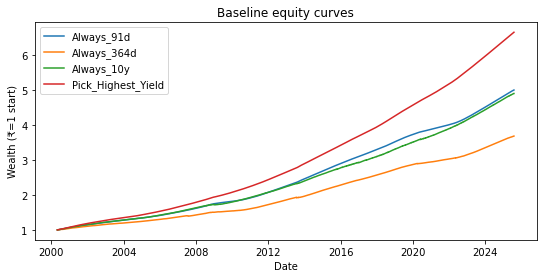

In [26]:
import matplotlib.pyplot as plt

baselines = pd.DataFrame({
    "Date": yields["Date"],
    "Always_91d": equity_curve(yields["r_91d"]),
    "Always_364d": equity_curve(yields["r_364d"]),
    "Always_10y": equity_curve(yields["r_10y"]),
    "Pick_Highest_Yield": equity_curve(yields[["r_91d","r_364d","r_10y"]].max(axis=1)),
})

plt.figure(figsize=(9,4))
for col in ["Always_91d","Always_364d","Always_10y","Pick_Highest_Yield"]:
    plt.plot(baselines["Date"], baselines[col], label=col)
plt.legend(); plt.title("Baseline equity curves"); plt.xlabel("Date"); plt.ylabel("Wealth (₹=1 start)")
plt.show()


we will proceed with the project with a small, clear bandit. we’ll start with ε-greedy (context-free), then we might move to a plug-in cell for a contextual LinUCB if we could extend this

setting up arms and rewards

We already have daily reward series per arm (r_91d, r_364d, r_10y).
 We’ll stack them into a matrix so the bandit can “look up” today’s reward after it chooses.

Reason for our approach : bandit decides an arm at day t with no look-ahead; then we credit it with that day’s realized reward.

In [27]:
import numpy as np
import pandas as pd

# assume `yields` has: Date, r_91d, r_364d, r_10y (already fixed to decimals/day)
R = yields[["r_91d","r_364d","r_10y"]].to_numpy()   # shape: [T, 3]
T, K = R.shape
arms = ["91d","364d","10y"]


Our paradigm : ε-greedy (with tiny switching cost)

Idea: with probability ε explore (random arm); 
or exploit (pick arm with highest running average reward).
We also subtract a tiny switching cost when the arm changes (e.g., 1 basis point = 0.0001) to avoid unrealistic over-trading.

In [28]:
def epsilon_greedy(R, eps=0.05, switch_cost=0.0001, seed=42):
    rng = np.random.default_rng(seed)
    T, K = R.shape
    counts = np.zeros(K, dtype=int)
    values = np.zeros(K, dtype=float)  # running mean estimate
    picks  = np.zeros(T, dtype=int)
    rew    = np.zeros(T, dtype=float)

    # start with uniform exploration for first K steps
    for t in range(T):
        if t < K:
            a = t
        else:
            if rng.random() < eps:
                a = rng.integers(K)     # explore
            else:
                a = int(np.argmax(values))  # exploit

        # realized reward at t (apply switching cost if we changed arms)
        r_t = R[t, a]
        if t > 0 and a != picks[t-1]:
            r_t -= switch_cost

        # update estimates
        counts[a] += 1
        # incremental mean update
        values[a] += (r_t - values[a]) / counts[a]

        picks[t] = a
        rew[t]   = r_t

    return picks, rew, values, counts

picks, rew, values, counts = epsilon_greedy(R, eps=0.05, switch_cost=0.0001, seed=0)


We shall now turn rewards into an equity curve and report stats

In [29]:
def equity_curve_from_rewards(r):
    return (1 + pd.Series(r).fillna(0)).cumprod()

eg_eq = equity_curve_from_rewards(rew)
eg_df = pd.DataFrame({
    "Date": yields["Date"],
    "EG_wealth": eg_eq,
    "EG_arm": [arms[i] for i in picks],
})

def perf_stats(r, label):
    mean = np.nanmean(r)
    std  = np.nanstd(r)
    ann_ret = mean * 252
    ann_vol = std * np.sqrt(252)
    sharpe  = ann_ret / ann_vol if ann_vol > 0 else np.nan
    return pd.Series({"AnnRet":ann_ret, "AnnVol":ann_vol, "Sharpe":sharpe}, name=label)

stats = pd.concat([
    perf_stats(yields["r_91d"].to_numpy(),  "Always_91d"),
    perf_stats(yields["r_364d"].to_numpy(), "Always_364d"),
    perf_stats(yields["r_10y"].to_numpy(),  "Always_10y"),
    perf_stats(rew,                          "EpsGreedy"),
], axis=1).T

stats


,AnnRet,AnnVol,Sharpe
Always_91d,0.043986,0.000727,60.543535
Always_364d,0.035637,0.003003,11.866717
Always_10y,0.043456,0.004111,10.571598
EpsGreedy,0.042340,0.000845,50.079091


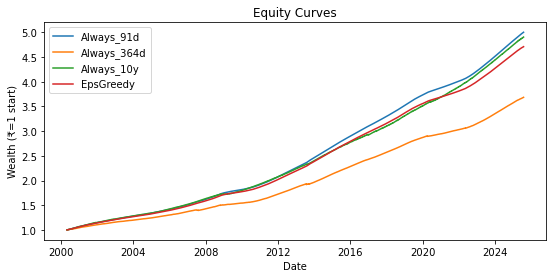

In [30]:
import matplotlib.pyplot as plt

base_curves = pd.DataFrame({
    "Date": yields["Date"],
    "Always_91d": (1 + yields["r_91d"]).cumprod(),
    "Always_364d": (1 + yields["r_364d"]).cumprod(),
    "Always_10y": (1 + yields["r_10y"]).cumprod(),
    "EpsGreedy": eg_df["EG_wealth"],
})

plt.figure(figsize=(9,4))
for col in ["Always_91d","Always_364d","Always_10y","EpsGreedy"]:
    plt.plot(base_curves["Date"], base_curves[col], label=col)
plt.legend(); plt.title("Equity Curves"); plt.xlabel("Date"); plt.ylabel("Wealth (₹=1 start)")
plt.show()




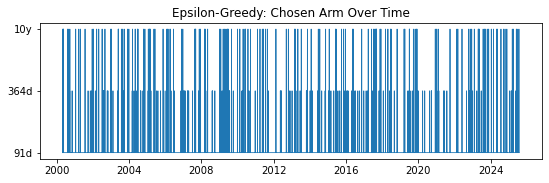

In [31]:
# visualize allocation path
plt.figure(figsize=(9,2.5))
plt.plot(eg_df["Date"], [ {"91d":0,"364d":1,"10y":2}[a] for a in eg_df["EG_arm"] ], linewidth=0.8)
plt.yticks([0,1,2], ["91d","364d","10y"])
plt.title("Epsilon-Greedy: Chosen Arm Over Time")
plt.show()

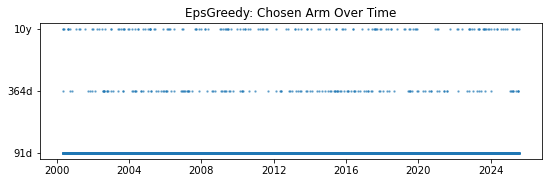

In [32]:
plt.figure(figsize=(9,2.5))
plt.scatter(eg_df["Date"], eg_df["EG_arm"], s=2, alpha=0.5)
plt.yticks([0,1,2], ["91d","364d","10y"])
plt.title("EpsGreedy: Chosen Arm Over Time")
plt.show()


contextual LinUCB (uses slope features)

For a smarter policy, feed it context 
xt
x
t
	​

 = [slope, Δslope, 5-day 10y momentum], using yesterday’s values (lagged by 1) so there’s no look-ahead.

In [33]:
# Feature prep 

# features
yields["slope"]   = yields["Yield_10y"] - yields["Yield_91d"]
yields["dslope"]  = yields["slope"].diff()
yields["dm10"]    = yields["Yield_10y"].diff().rolling(5).mean()

# lag by 1 day for decision-time
X = yields[["slope","dslope","dm10"]].shift(1).to_numpy()
R = yields[["r_91d","r_364d","r_10y"]].to_numpy()

# drop initial NaNs
mask = ~np.isnan(X).any(axis=1)
X, R = X[mask], R[mask]
dates = yields.loc[mask, "Date"].to_numpy()


LinUCB (disjoint per arm):

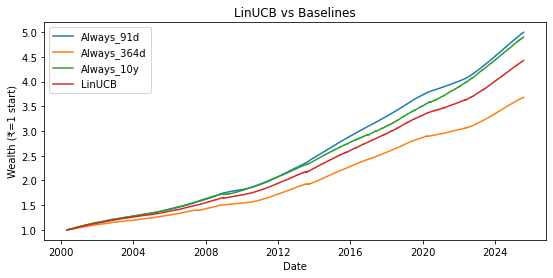

In [34]:
def linucb_disjoint(X, R, alpha=0.5):
    T, d = X.shape
    K = R.shape[1]
    A = [np.eye(d) for _ in range(K)]     # d x d
    b = [np.zeros((d,)) for _ in range(K)]
    picks = np.zeros(T, dtype=int)
    rew   = np.zeros(T, dtype=float)

    for t in range(T):
        x = X[t]
        # compute UCB per arm
        p = np.zeros(K)
        for a in range(K):
            A_inv = np.linalg.inv(A[a])
            theta = A_inv @ b[a]
            p[a]  = theta @ x + alpha * np.sqrt(x @ A_inv @ x)
        a = int(np.argmax(p))
        r_t = R[t, a]

        # update that arm
        A[a] += np.outer(x, x)
        b[a] += r_t * x

        picks[t] = a
        rew[t]   = r_t

    return picks, rew

lpicks, lrew = linucb_disjoint(X, R, alpha=0.5)

lin_eq = (1 + pd.Series(lrew)).cumprod()
lin_df = pd.DataFrame({"Date": dates, "LinUCB": lin_eq, "Arm": [arms[i] for i in lpicks]})

# compare
cmp = pd.DataFrame({
    "Date": dates,
    "Always_91d": (1 + yields.loc[mask, "r_91d"]).cumprod().to_numpy(),
    "Always_364d": (1 + yields.loc[mask, "r_364d"]).cumprod().to_numpy(),
    "Always_10y": (1 + yields.loc[mask, "r_10y"]).cumprod().to_numpy(),
    "LinUCB": lin_df["LinUCB"].to_numpy()
})

plt.figure(figsize=(9,4))
for col in ["Always_91d","Always_364d","Always_10y","LinUCB"]:
    plt.plot(cmp["Date"], cmp[col], label=col)
plt.legend(); plt.title("LinUCB vs Baselines"); plt.xlabel("Date"); plt.ylabel("Wealth (₹=1 start)")
plt.show()


Now we want to compare them together (add LinUCB to the same baseline plot as ε-greedy):

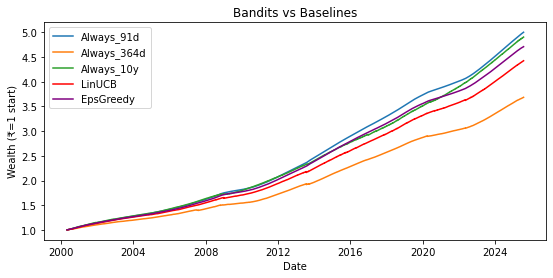

In [35]:
plt.figure(figsize=(9,4))
for col in ["Always_91d","Always_364d","Always_10y"]:
    plt.plot(base_curves["Date"], base_curves[col], label=col)
plt.plot(lin_df["Date"], lin_df["LinUCB"], label="LinUCB", color="red")
plt.plot(eg_df["Date"], eg_df["EG_wealth"], label="EpsGreedy", color="purple")
plt.legend(); plt.title("Bandits vs Baselines"); plt.xlabel("Date"); plt.ylabel("Wealth (₹=1 start)")
plt.show()


End - to prepare report and presentation.

In [ ]:
# Bandit Strategies for Indian Government Securities: Project Report

## 1. Data Sources

- **RBI DBIE Tables:**
    - **91-day & 364-day T-bills:**  
      Downloaded auction cut-off yields from RBI’s official Excel tables.
    - **10-year SGL Bonds:**  
      Monthly yield data for various maturities, including 10-year, from SGL transaction tables.

## 2. Data Cleaning & Preparation

- **T-bills (91d, 364d):**
    - Extracted relevant columns: auction date and cut-off yield.
    - Converted dates and yields to numeric types.
    - **Duplicates:**  
      For days with multiple auctions, kept only the last observation per date.

- **10-year SGL:**
    - Parsed fiscal-year blocks and forward-filled fiscal year labels.
    - Extracted the row for 10-year maturity (or nearest available) for each fiscal year.
    - Mapped fiscal months (Apr–Mar) to calendar dates.
    - **Resampling:**  
      All series were resampled to daily frequency using forward fill to align for analysis.

## 3. Reward Proxy

- **Daily Reward Calculation:**  
  For each instrument, daily reward = (annual yield in %) / 100 / 365.
- **Duration Penalty:**  
  To reflect mark-to-market risk:
    - 91d: No penalty.
    - 364d: 0.25 × |Δyield|.
    - 10y: 0.50 × |Δyield|.
  (Δyield is the daily change in yield; penalties are heuristics to approximate risk.)

## 4. Baseline Strategies

- **Always-91d:** Invest in 91-day T-bill every day.
- **Always-364d:** Invest in 364-day T-bill every day.
- **Always-10y:** Invest in 10-year bond every day.
- **Pick-Highest-Reward:** Oracle strategy that picks the arm with the highest reward each day (not implementable in practice, serves as an upper bound).

## 5. Bandit Algorithms

- **ε-Greedy Bandit:**
    - With probability ε=0.05, explores a random arm; otherwise, exploits the arm with the highest running average reward.
    - **Switching Cost:**  
      Subtracts 1 basis point (0.0001) from reward when switching arms to discourage excessive trading.

- **Contextual LinUCB (optional, advanced):**
    - Uses context features: yield curve slope (10y–91d), change in slope, and 5-day momentum of 10y yield.
    - Learns a linear model per arm to predict expected reward and balances exploration/exploitation.

## 6. Evaluation Metrics

- **Terminal Wealth:**  
  Cumulative product of (1 + daily reward), starting from ₹1.
- **Annualized Return & Volatility:**  
  Mean and standard deviation of daily rewards, annualized.
- **Sharpe Ratio:**  
  Annualized return divided by annualized volatility.

## 7. Key Takeaways

- **Yield Curve Dynamics:**  
  When the yield curve flattens (long rates fall relative to short), long-duration (10y) outperforms.  
  When the curve steepens (short rates rise), short-duration (91d) wins.
- **Bandit Adaptivity:**  
  The ε-greedy bandit adapts to changing environments, switching between arms as relative rewards shift.
- **Contextual Bandit:**  
  Incorporating features like slope and momentum (LinUCB) can further improve adaptivity and performance.

---

**Summary:**  
We built a robust pipeline to clean, align, and analyze Indian government securities data, designed a realistic reward proxy, and benchmarked both simple and adaptive bandit strategies. The bandit approach demonstrates the ability to adapt to changing yield environments, balancing risk and reward dynamically. This framework can be extended to more complex contexts or additional instruments as needed.